<a href="https://colab.research.google.com/github/Ok3ks/Disso-COLD/blob/main/IMDB_BERT_chunk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%pip install transformers 
%pip install sklearn
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments,DataCollatorWithPadding
from datasets import load_dataset, load_metric,Dataset
import torch
import numpy as np
from datasets import load_dataset
from utils import PrepareCorpus,AssessData
from sklearn.model_selection import train_test_split
from datasets import Dataset,load_dataset
import json
from re import template
from sklearn.model_selection import KFold

In [6]:
number = range(50,150,50); _per_segment = range(200,400,100); max_input_length = 300

overlap = {"side":"both", "number": 50}; f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

def tokenize(batch):
    return bert_tokenizer(batch['text'], truncation=True, max_length=max_input_length,padding = True)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):
  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.00001,0.00005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)}

def bert_init():
  return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

def id_2_labels(x,adict):
  """converts labels/classes into a number using a dictionary"""
  return adict[x]

def _indexing(alist):
  id = 0; indexed = {}
  for x in alist:
    for y in x:
      id +=1
      indexed[id] = y
  return indexed

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
imdb = load_dataset("imdb")
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
#0 corresponds to negative review while 1 corresponds to positive reviews
label2text = {0:'negative', 1: 'positive'}

train_imdb = imdb['train']
test_imdb = imdb['test']
set(train_imdb['label'])

imdb_train_text = {i:x for i,x in enumerate(train_imdb['text'])}
imdb_test_text = {i:x for i,x in enumerate(test_imdb['text'])}

temp = []
imdb_labels_text_train = {i:temp.append(x) for i,x in zip(train_imdb['label'], train_imdb['text'])}

temp = []
imdb_labels_text_test = {i:temp.append(x) for i,x in zip(test_imdb['label'], test_imdb['text'])}

imdb_train_labels = {i:x for i,x in enumerate(train_imdb['label'])}
imdb_test_labels = {i:x for i,x in enumerate(test_imdb['label'])}

In [9]:
train_imdb_assess = AssessData(imdb_train_text, imdb_labels_text_train)
test_imdb_assess = AssessData(imdb_test_text, imdb_labels_text_test)

In [10]:
!pip install nltk
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

{'Too Long': 0, 'Long': 3012, 'BERT': 4759, 'Short': 17229}


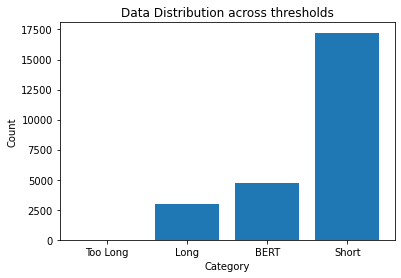

{'Too Long': 0, 'Long': 2803, 'BERT': 4639, 'Short': 17558}


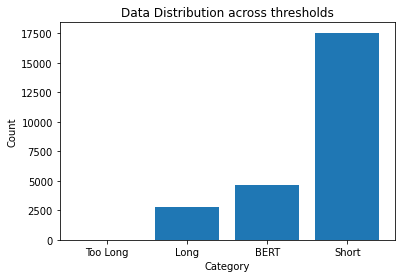

In [11]:
train_imdb_assess._create_distribution()
train_imdb_assess._visualise()

test_imdb_assess._create_distribution()
test_imdb_assess._visualise()

TRAINING ON THE FULL DATASET

In [12]:
train_set = train_imdb_assess._chunk(200, overlap=overlap)
train_index, train_text = zip(*train_set)

#Creates dictionary for train_index and train_text

train_index = {a:x for a,x in enumerate(train_index)}
train_text = {a:x for a,x in enumerate(train_text)}

In [13]:
test_set = test_imdb_assess._chunk(200, overlap=overlap)
test_index, test_text = zip(*test_set)

#Creates dictionary for test_index and test_text

test_index = {a:x for a,x in enumerate(test_index)}
test_text = {a:x for a,x in enumerate(test_text)}

In [14]:
train_index

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 3,
 23: 3,
 24: 3,
 25: 3,
 26: 3,
 27: 4,
 28: 4,
 29: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 4,
 35: 4,
 36: 4,
 37: 4,
 38: 5,
 39: 5,
 40: 5,
 41: 5,
 42: 5,
 43: 6,
 44: 6,
 45: 6,
 46: 6,
 47: 6,
 48: 7,
 49: 7,
 50: 7,
 51: 7,
 52: 7,
 53: 7,
 54: 7,
 55: 7,
 56: 7,
 57: 7,
 58: 8,
 59: 8,
 60: 8,
 61: 8,
 62: 8,
 63: 8,
 64: 8,
 65: 8,
 66: 8,
 67: 8,
 68: 8,
 69: 8,
 70: 8,
 71: 8,
 72: 8,
 73: 8,
 74: 9,
 75: 9,
 76: 9,
 77: 9,
 78: 9,
 79: 9,
 80: 9,
 81: 9,
 82: 10,
 83: 10,
 84: 10,
 85: 10,
 86: 10,
 87: 10,
 88: 10,
 89: 10,
 90: 10,
 91: 11,
 92: 11,
 93: 11,
 94: 11,
 95: 11,
 96: 12,
 97: 12,
 98: 12,
 99: 12,
 100: 12,
 101: 13,
 102: 13,
 103: 13,
 104: 13,
 105: 13,
 106: 14,
 107: 14,
 108: 14,
 109: 14,
 110: 14,
 111: 14,
 112: 14,
 113: 14,
 114: 14,
 115: 14,
 116: 14,
 117: 14,
 118: 15,
 1

In [15]:
list(test_index.values())[-1]

24999

In [16]:
#Creates dictionary of labels

train_chunked_label = {i:imdb_train_labels[x] for i,x in train_index.items()}
test_chunked_label = {i:imdb_test_labels[x] for i,x in test_index.items()}

In [17]:
train_set = {"train" : {"text": train_text.values(), "doc_id": train_index.values(), "labels": train_chunked_label.values()}}
test_set =  {"test" : {"text": test_text.values(), 'doc_id': test_index.values(), 'labels': test_chunked_label.values()}}

In [18]:
import pandas as pd

a = pd.DataFrame(train_set['train'])
b = pd.DataFrame(test_set['test'])

In [19]:
a

,text,doc_id,labels
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,0
1,d by U.S. customs if it ever tried to enter th...,0,0
2,Swedish drama student named Lena who wants to ...,0,0
3,about certain political issues such as the Vie...,0,0
4,"sex with her drama teacher, classmates, and ma...",0,0
...,...,...,...
203180,"zie!"". Time to end this review. I have to go t...",24998,1
203181,,24998,1
203182,The story centers around Barry McKenzie who mu...,24999,1
203183,eat Nation of ours there is something of a cul...,24999,1


In [20]:
#Modify types
a['text'] = a['text'].astype(str)
a['labels'] = a['labels'].astype(int)

b['text'] = b['text'].astype(str)
b['labels'] = b['labels'].astype(int)

In [21]:
train_set = Dataset.from_pandas(a)
test_set = Dataset.from_pandas(b)

In [22]:
train_set = train_set.shuffle(seed = 32)
#test_set = test_set.shuffle(seed = 32)

In [23]:
train_set = train_set.map(tokenize)

  0%|          | 0/203185 [00:00<?, ?ex/s]

In [24]:
test_set = test_set.map(tokenize)

  0%|          | 0/199213 [00:00<?, ?ex/s]

In [25]:
split = train_set.train_test_split(test_size = 0.1)

In [26]:
split_train_set = split['train']
split_valid_set = split['test']

In [27]:
from sklearn.model_selection import KFold

fold = KFold(n_splits = 5)
fold = fold.split(train_set)

fold_train = []
fold_test = []

for i, j in fold:
  fold_train.append(i)
  fold_test.append(j)

temp_train_set = train_set.select(fold_train[0])
temp_test_set = train_set.select(fold_test[0])  

In [ ]:
training_args = TrainingArguments("./results_temp", learning_rate=5e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=13, weight_decay=0.01)
results = []

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, max_length= 300, padding = True)

#Fine-tune
trainer = Trainer(model = model, 
                args = training_args,
                train_dataset= temp_train_set,
                eval_dataset= temp_test_set,
                tokenizer= bert_tokenizer,
                data_collator=data_collator,
                compute_metrics= compute_metrics)

trainer.train(resume_from_checkpoint = True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from ./results_temp/checkpoint-52500.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 162548
  Num Epochs = 13
 

  0%|          | 0/8560 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Step,Training Loss
100500,0.102800
101000,0.105100
101500,0.102800
102000,0.099300
102500,0.095700
103000,0.112400
103500,0.102500
104000,0.110700
104500,0.102900
105000,0.108500


Saving model checkpoint to ./results_temp/checkpoint-100500
Configuration saved in ./results_temp/checkpoint-100500/config.json
Model weights saved in ./results_temp/checkpoint-100500/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-100500/tokenizer_config.json
Special tokens file saved in ./results_temp/checkpoint-100500/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Saving model checkpoint to ./results_temp/checkpoint-101000
Configuration saved in ./results_temp/checkpoint-101000/config.json
Model weights saved in ./results_temp/checkpoint-101000/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-101000/tokenizer_config.json
Special tokens file

Step,Training Loss
100500,0.102800
101000,0.105100
101500,0.102800
102000,0.099300
102500,0.095700
103000,0.112400
103500,0.102500
104000,0.110700
104500,0.102900
105000,0.108500


Saving model checkpoint to ./results_temp/checkpoint-127000
Configuration saved in ./results_temp/checkpoint-127000/config.json
Model weights saved in ./results_temp/checkpoint-127000/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-127000/tokenizer_config.json
Special tokens file saved in ./results_temp/checkpoint-127000/special_tokens_map.json
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2340: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Saving model checkpoint to ./results_temp/checkpoint-127500
Configuration saved in ./results_temp/checkpoint-127500/config.json
Model weights saved in ./results_temp/checkpoint-127500/pytorch_model.bin
tokenizer config file saved in ./results_temp/checkpoint-127500/tokenizer_config.json
Special tokens file

In [32]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 40637
  Batch size = 16


Trainer is attempting to log a value of "{'f1': 0.8097298646442376}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8171834374302338}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8108620222949529}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9385738968849182,
 'eval_f1': {'f1': 0.8097298646442376},
 'eval_precision': {'precision': 0.8171834374302338},
 'eval_recall': {'recall': 0.8108620222949529},
 'eval_runtime': 103.1435,
 'eval_samples_per_second': 393.985,
 'eval_steps_per_second': 24.626,
 'epoch': 13.0}

In [35]:
results = trainer.predict(test_set)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: doc_id, text. If doc_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 199213
  Batch size = 16


In [36]:
test_pred = list(np.argmax(results.predictions, axis = 1))

In [37]:
import pickle

with open("imdb_final_output_pred.pkl", "wb") as outs:
  pickle.dump(test_pred, outs)

In [ ]:
while True:pass